# Neural Style Transfer

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt

import copy
from scipy import ndimage

## Style transfer

The Neural Style Transfer is an algorithm that takes as input a content-image and a style-image and returns the content of the content-image as if it was ‘painted’ using the artistic style of the style-image.

For a style image I will use "The Jungle", 1942-43. <it>The Jungle</it> is a painting from the Cuban artist Wifredo Lam.

In [2]:
PATH = Path("/data2/yinterian/style-transfer/")

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(1198, 940, 3)

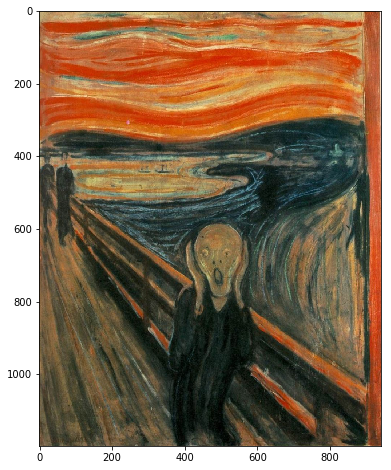

In [4]:
path = PATH/"lam2.jpg"
path = PATH/"scream.jpg"
im1 = read_image(path)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im1)
im1.shape

To get this image: <br>
`wget https://uploads4.wikiart.org/images/wifredo-lam/le-sombre-malembo-dieu-du-carrefour-1943.jpg` <br>
`mv le-sombre-malembo-dieu-du-carrefour-1943.jpg lam2.jpg`

Here is my content image. This a picture of my son. You can use your favorite content image.

(4032, 3024, 3)

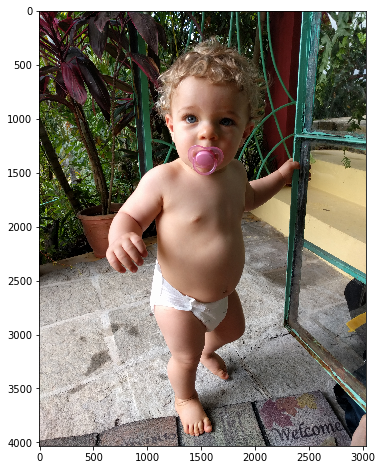

In [5]:
path2 = PATH/"ari.jpg"
im2 = read_image(path2)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im2)
im2.shape

## Preprocessing
We need style and content images of the same size.

In [6]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

(300, 300, 3)

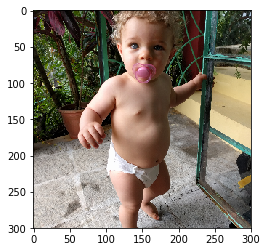

In [7]:
im2 = center_crop(im2)
im2 = cv2.resize(im2, (300, 300))
plt.imshow(im2)
im2.shape

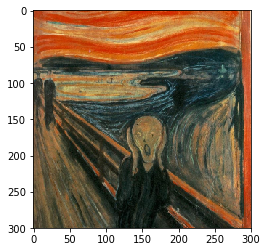

In [8]:
im1 = center_crop(im1)
im1 = cv2.resize(im1, (300, 300))
im1.shape
plt.imshow(im1)

In [9]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [10]:
im_style = transform_images(im1/255)
im_content = transform_images(im2/255)

In [11]:
im_style.shape

torch.Size([1, 3, 300, 300])

## Prepare vgg19

In [12]:
# get vgg16 model
vgg = models.vgg19(True).cuda().eval()

In [13]:
list(vgg.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace)
   (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (17): ReLU(inplace)
   (18): MaxPool2d(kernel_size=2, s

In [88]:
layers = list(vgg.children())[0]

#m_vgg = nn.Sequential(*layers[:19]) # after conv4_1
m_vgg = nn.Sequential(*layers[:10]) # after conv3_1
# freezing parameters
for param in m_vgg.parameters():
    param.requires_grad = False

In [89]:
# indices for all Relus
block_relu = [i for i,o in enumerate(layers)
              if isinstance(o, nn.ReLU)]
block_relu

[1, 3, 6, 8, 11, 13, 15, 17, 20, 22, 24, 26, 29, 31, 33, 35]

In [90]:
# indices for all MaxPool2d
[i for i,o in enumerate(layers) if isinstance(o, nn.MaxPool2d)]

[4, 9, 18, 27, 36]

## Content optimization

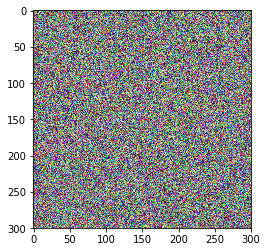

In [91]:
# start with a random image
opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
plt.imshow(opt_img)

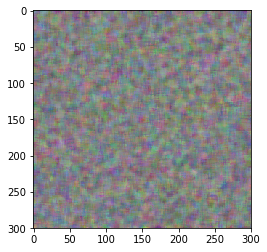

In [92]:
opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
opt_img = opt_img 
plt.imshow(opt_img)

In [93]:
im_opt = transform_images(opt_img)
im_opt.shape

torch.Size([1, 3, 300, 300])

In [94]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
im_opt.requires_grad=True

In [95]:
# Making the image pixes the parameters of the model
optimizer = optim.LBFGS([im_opt], lr=0.01)

In [96]:
# the target here is the output of the content image
# after vgg19
targ_v = m_vgg(im_content).detach()
targ_v.shape

torch.Size([1, 128, 75, 75])

In [97]:
F.mse_loss(m_vgg(im_opt), targ_v).item()

2.7341556549072266

In [98]:
# for optim.LBFGS we have to define a closure function
def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            loss = F.mse_loss(m_vgg(im_opt), targ_v)
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            print(i, (F.mse_loss(m_vgg(im_opt), targ_v)).item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [99]:
im_opt = train_image(optimizer, targ_v, im_opt, 1000)

1 1.9262133836746216
51 0.3158590793609619
101 0.2292703092098236
151 0.2112390398979187
201 0.20095402002334595
251 0.1398826390504837
301 0.12749837338924408
351 0.12505222856998444
401 0.1229768916964531
451 0.10380557924509048
501 0.09789445251226425
551 0.09615733474493027
601 0.09476075321435928
651 0.0893998071551323
701 0.08537493646144867
751 0.08462122827768326
801 0.08345620334148407
851 0.08196812868118286
901 0.07536888867616653
951 0.07454697042703629


In [100]:
x = im_opt.cpu().detach().numpy()

In [101]:
x = x[0]
x.shape

(3, 300, 300)

In [102]:
x = np.rollaxis(x,0,3)

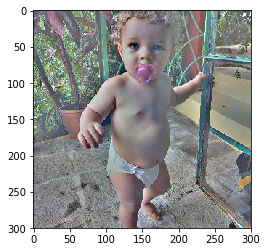

In [103]:
plt.imshow(x)

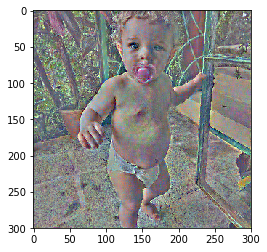

In [30]:
plt.imshow(x) # layer 20

## Style Optimization

For style optimization we will be using conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1. These correspond to indices: `[0, 5, 10, 19, 28]`.

In [130]:
def get_input(lr=0.01, alpha=0.1):
    opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img = (1-alpha)*opt_img + alpha*im2/255
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.LBFGS([im_opt], lr=0.01)
    return im_opt, optimizer
im_opt, optimizer = get_input()

In [141]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        #self.select = ['0', '5', '10', '19', '28'] 
        self.select = ['0', '5', '10', '19'] 
        self.vgg = models.vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [142]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # unrolling feature maps

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [143]:
opt_img, optimizer = get_input(lr=0.1, alpha=0.0)
vgg = VGGNet().cuda().eval()

In [144]:
im_style_f = vgg(im_style)

In [145]:
[o.shape for o in im_style_f]

[torch.Size([1, 64, 300, 300]),
 torch.Size([1, 128, 150, 150]),
 torch.Size([1, 256, 75, 75]),
 torch.Size([1, 512, 37, 37])]

In [146]:
# note that gram_matrix(f) is location independent
targ_g = [gram_matrix(f).detach() for f in im_style_f]
[o.shape for o in targ_g]

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512])]

In [147]:
def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%100 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            print(i, loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [148]:
im_opt, optimizer = get_input(lr=0.1, alpha=0.0)

In [149]:
im_opt = train_style(optimizer, targ_g, im_opt, 1000)

1 0.07748052477836609
101 0.0006601788918487728
201 0.00028193806065246463
301 0.00025147193809971213
401 0.00025143875973299146
501 0.0002514238585717976
601 0.00025141192600131035
701 0.00025140069192275405
801 0.0002513899526093155
901 0.0002513799408916384


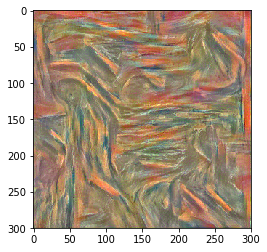

In [150]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

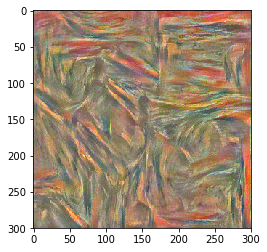

In [140]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

## Style transfer

In [42]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, alpha=1.5):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [43]:
im_style_f = vgg(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

In [44]:
im_content_f = vgg(im_content)
targ_v = im_content_f[2].detach()
targ_v.shape

torch.Size([1, 256, 75, 75])

In [54]:
im_opt, optimizer = get_input(lr=0.5)

In [46]:
im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=5000)

38.739017486572266
3.07108736038208
2.2715935707092285
2.0581746101379395
1.981245994567871
1.9494361877441406
1.9355762004852295
1.847704291343689
1.7852381467819214
1.7759945392608643
1.7717564105987549
1.7323670387268066
1.7064670324325562
1.7032620906829834
1.7015955448150635
1.6837983131408691
1.661668300628662
1.6588971614837646
1.657523512840271
1.6462855339050293


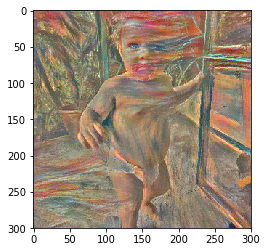

In [47]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

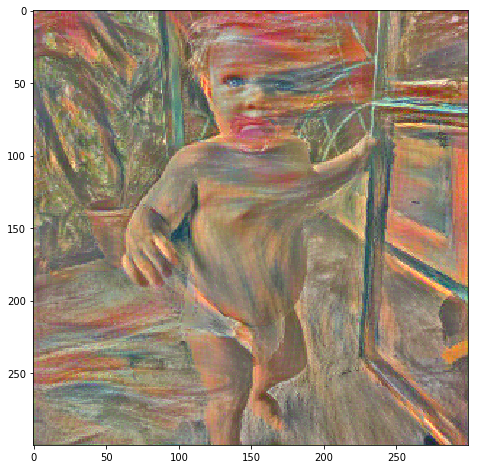

In [48]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)

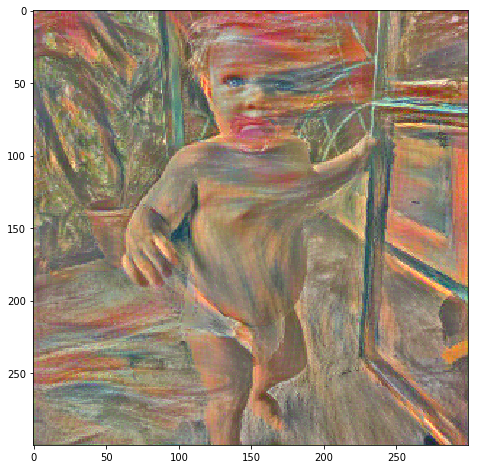

In [49]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)

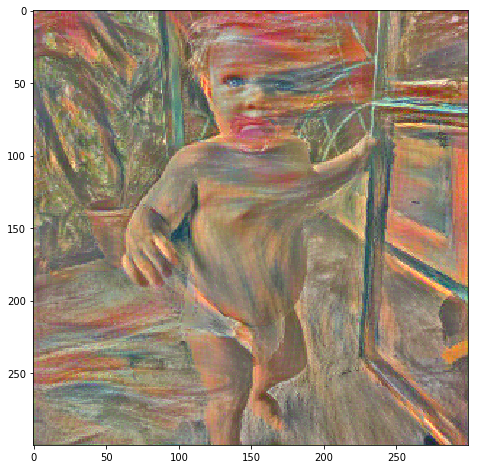

In [50]:
#1000 iterations
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)

# References
The idea for the model in this notebook is based on notebook is based on this [pytorch tutorial](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/neural_style_transfer/main.py). I also looked at these other notebooks and papers:

* This [fast.ai notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb) 
* This [paper](https://arxiv.org/pdf/1508.06576.pdf).
* This [block post](https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199)